In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import optuna

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold

import optuna
from optuna.samplers import TPESampler

## Read data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
train.drop(columns=['id'], axis=1, inplace=True)
test.drop(columns=['id'], axis=1, inplace=True)

## Preprocess data

In [8]:
encoder = LabelEncoder()
scaler = MinMaxScaler()

train['Sex'] = encoder.fit_transform(train['Sex'])
test['Sex'] = encoder.transform(test['Sex'])

cat_cols = ['Sex']
target = 'Rings'
continuous_cols = [col for col in train.columns if col not in cat_cols + [target]]

train[continuous_cols] = scaler.fit_transform(train[continuous_cols])
test[continuous_cols] = scaler.transform(test[continuous_cols])

X = train.drop(columns=['Rings'], axis=1).values
y = train['Rings'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.27, random_state=24)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDataset instances for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
batch_size = 70
# Create DataLoader instances for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Define network

In [9]:
class TabTransformerModel(nn.Module):
    """
    TabTransformer model for regression.
    """
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, dropout):
        """
        Initialize the TabTransformer model.
        
        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Hidden dimension of the transformer.
            num_layers (int): Number of transformer encoder layers.
            num_heads (int): Number of attention heads.
            dropout (float): Dropout probability.
        """
        super(TabTransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, input_dim + 1, hidden_dim))
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_dim, num_heads, dim_feedforward=hidden_dim*4, dropout=dropout, batch_first=True),
            num_layers
        )
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        """
        Perform forward pass through the TabTransformer model.
        
        Args:
            x (torch.Tensor): Input tensor.
            
        Returns:
            torch.Tensor: Model output.
        """
        x = self.embedding(x)
        cls_tokens = self.cls_token.repeat(x.size(0), 1, 1)
        x = torch.cat([cls_tokens, x.unsqueeze(1)], dim=1)
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = x[:, 0, :]
        x = self.fc(x)
        return x

## Define early stopper

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
# Define hyperparameters
input_dim = X_train_tensor.shape[1]  # Number of features
params = {'hidden_dim': 144, 'num_heads': 9, 'num_layers': 2, 
          'dropout': 0.11536065466933315}

# Initialize the model
model = TabTransformerModel(input_dim, **params).to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Define training loop

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 3.8548, Val Loss: 3.8879


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 3.8209, Val Loss: 4.3066


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 3.8023, Val Loss: 3.6624


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 3.8029, Val Loss: 3.6465


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 3.7737, Val Loss: 5.1150


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 3.7838, Val Loss: 4.2577


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

Early stopping at epoch 7


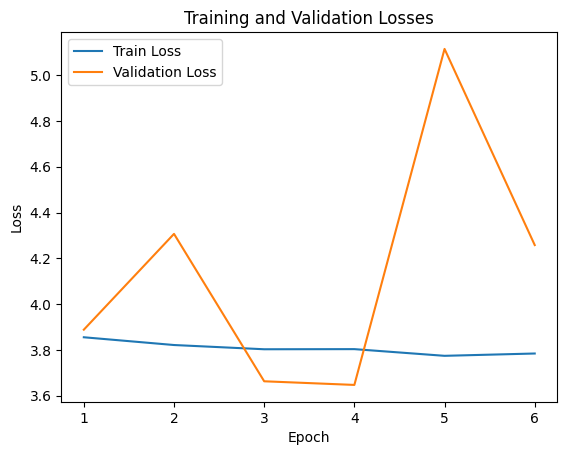

In [17]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize best_val_loss here
best_model_state = None
patience_counter = 0
early_stopping_patience = 3  # Define the patience for early stopping


EPOCHS = 20
initial_lr = 0.001  # Start with a small learning rate
lr_step_size = 6   # Update the learning rate every 6 epochs
lr_gamma = 0.1      # Multiply the learning rate by 0.1 every lr_step_size epochs
criterion = nn.MSELoss()
early_stopping = EarlyStopping(tolerance=3, min_delta=0.1)

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

# Define your learning rate scheduler
scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

train_losses = []
val_losses = []

for epoch in trange(EPOCHS):
    # Training phase
    avg_train_loss = []
    model.train()  # Set model to training mode
    for i, (image, mask) in enumerate(tqdm(train_loader)):
        image, mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(image)
        mask = mask.view(-1, 1) 
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        avg_train_loss.append(loss.item())

    avg_train_loss = np.mean(avg_train_loss)

    # Validation phase
    avg_val_loss = []
    model.eval()  # Set model to evaluation mode
    for j, (image, mask) in enumerate(tqdm(val_loader)):
        image, mask = image.to(device), mask.to(device)
        with torch.no_grad():
            output = model(image)
            mask = mask.view(-1, 1)
            loss = criterion(output, mask)
            avg_val_loss.append(loss.item())

    avg_val_loss = np.mean(avg_val_loss)

     # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    tqdm.write(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Apply learning rate scheduling
    scheduler.step()

    # Append the losses for this epoch
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

# Create a DataFrame to store the losses
loss_df = pd.DataFrame({'val_loss': val_losses, 'train_loss': train_losses})

# Plot the losses
plt.plot(loss_df.index + 1, loss_df['train_loss'], label='Train Loss')
plt.plot(loss_df.index + 1, loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

## Inference

In [27]:
# Inference

test_tensor = torch.tensor(test.values, dtype=torch.float32).to(device)
with torch.no_grad():
    model.eval()
    predictions = model(test_tensor)
predictions

tensor([[ 9.7133],
        [ 9.6166],
        [10.1554],
        ...,
        [12.7128],
        [13.0745],
        [ 8.5461]], device='cuda:0')

## Hyperparameter tune 

In [7]:
def train_model(params):
    """
    Train the FT-Transformer model with the given hyperparameters.
    
    Args:
        params (dict): Hyperparameters for the model.
        
    Returns:
        float: Average validation RMSE across folds.
    """
    # Unpack the hyperparameters
    input_dim = X_train_tensor.shape[1]
    hidden_dim = params['hidden_dim']
    num_layers = params['num_layers']
    num_heads = params['num_heads']
    dropout = params['dropout']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    early_stopping_patience = params['early_stopping_patience']
    
    # Set the device (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create the FT-Transformer model
    model = TabTransformerModel(input_dim, hidden_dim, num_layers, num_heads, dropout).to(device)
    
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create KFold cross-validator
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    best_val_rmse_folds = []
    
    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_tensor)):
        print(f"Fold [{fold+1}/3]")

        # Create train and validation datasets using the indices
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset = torch.utils.data.TensorDataset(X_train_tensor[val_idx], y_train_tensor[val_idx])

        # Create data loaders for train and validation datasets
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

        # Initialize variables for early stopping
        best_val_rmse = float('inf')  # Initialize best_val_rmse here
        best_model_state = None
        patience_counter = 0

        # Training loop
        for epoch in tqdm(range(num_epochs)):
            model.train()
            
            # Iterate over the training batches
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
            
            model.eval()
            val_predictions = []
            val_targets = []
            
            # Iterate over the validation batches
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    val_predictions.append(outputs.squeeze().cpu().numpy())
                    val_targets.append(batch_y.cpu().numpy())
            
            # Concatenate the validation predictions and targets
            val_predictions = np.concatenate(val_predictions)
            val_targets = np.concatenate(val_targets)
            
            # Calculate validation RMSE
            val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation RMSE: {val_rmse:.4f}")
            
            # Check for early stopping
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        # Store the best validation RMSE for the current fold
        best_val_rmse_folds.append(best_val_rmse)
        
        # Load the best model state for the current fold
        model.load_state_dict(best_model_state)
    
    # Calculate the average validation RMSE across all folds
    avg_val_rmse = np.mean(best_val_rmse_folds)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f}")
    
    return avg_val_rmse

def objective(trial):
    """
    Objective function for hyperparameter optimization.
    
    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        
    Returns:
        float: Average validation RMSE.
    """
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256, step=16)
    num_heads = trial.suggest_int('num_heads', 2, hidden_dim // 16)
    
    while hidden_dim % num_heads != 0:
        num_heads -= 1
    
    params = {
        'hidden_dim': hidden_dim,
        'num_layers': trial.suggest_int('num_layers', 1, 4),
        'num_heads': num_heads,
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'num_epochs': 200,
        'batch_size': trial.suggest_int('batch_size', 16, 128),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'early_stopping_patience': 10
    }
    
    avg_val_rmse = train_model(params)
    
    return avg_val_rmse

# Create an Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(multivariate=True))

# # Optimize the hyperparameters
study.optimize(objective, timeout=3600 * 10)

# # Print the best hyperparameters and validation RMSE
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)


/opt/conda/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-04-17 09:18:07,711] A new study created in memory with name: no-name-ab859cdf-525a-4ef1-b22b-aca106b763c1


Fold [1/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 3.3892
Epoch [2/200], Validation RMSE: 3.4249
Epoch [3/200], Validation RMSE: 3.3612
Epoch [4/200], Validation RMSE: 3.2979
Epoch [5/200], Validation RMSE: 3.3037
Epoch [6/200], Validation RMSE: 3.3718
Epoch [7/200], Validation RMSE: 3.4977
Epoch [8/200], Validation RMSE: 3.4921
Epoch [9/200], Validation RMSE: 3.6866
Epoch [10/200], Validation RMSE: 3.7448
Epoch [11/200], Validation RMSE: 3.3839
Epoch [12/200], Validation RMSE: 3.5652
Epoch [13/200], Validation RMSE: 3.5061
Epoch [14/200], Validation RMSE: 3.4700
Early stopping at epoch 14
Fold [2/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 3.6461
Epoch [2/200], Validation RMSE: 3.6698
Epoch [3/200], Validation RMSE: 3.3816
Epoch [4/200], Validation RMSE: 3.4631
Epoch [5/200], Validation RMSE: 3.6112
Epoch [6/200], Validation RMSE: 3.4127
Epoch [7/200], Validation RMSE: 3.5230
Epoch [8/200], Validation RMSE: 3.4703
Epoch [9/200], Validation RMSE: 3.4617
Epoch [10/200], Validation RMSE: 3.5625
Epoch [11/200], Validation RMSE: 3.3131
Epoch [12/200], Validation RMSE: 3.3701
Epoch [13/200], Validation RMSE: 3.3625
Epoch [14/200], Validation RMSE: 3.3768
Epoch [15/200], Validation RMSE: 3.2725
Epoch [16/200], Validation RMSE: 3.2899
Epoch [17/200], Validation RMSE: 3.2990
Epoch [18/200], Validation RMSE: 3.2576
Epoch [19/200], Validation RMSE: 3.2313
Epoch [20/200], Validation RMSE: 3.2303
Epoch [21/200], Validation RMSE: 3.2460
Epoch [22/200], Validation RMSE: 3.2590
Epoch [23/200], Validation RMSE: 3.2402
Epoch [24/200], Validation RMSE: 3.2439
Epoch [25/200], Validation RMSE: 3.2320
Epoch [26

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 3.1897
Epoch [2/200], Validation RMSE: 3.1918
Epoch [3/200], Validation RMSE: 3.1968
Epoch [4/200], Validation RMSE: 3.2227
Epoch [5/200], Validation RMSE: 3.2561
Epoch [6/200], Validation RMSE: 3.1904
Epoch [7/200], Validation RMSE: 3.2195
Epoch [8/200], Validation RMSE: 3.1952
Epoch [9/200], Validation RMSE: 3.1916
Epoch [10/200], Validation RMSE: 3.2500


[I 2024-04-17 09:20:32,108] Trial 0 finished with value: 3.2271366119384766 and parameters: {'hidden_dim': 176, 'num_heads': 6, 'num_layers': 1, 'dropout': 0.2773636244490308, 'batch_size': 121, 'learning_rate': 0.002580320372586661}. Best is trial 0 with value: 3.2271366119384766.


Epoch [11/200], Validation RMSE: 3.1966
Early stopping at epoch 11
Average Validation RMSE across folds: 3.2271
Fold [1/3]


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 2.2609
Epoch [2/200], Validation RMSE: 2.0253
Epoch [3/200], Validation RMSE: 2.0490
Epoch [4/200], Validation RMSE: 1.9465
Epoch [5/200], Validation RMSE: 1.9301
Epoch [6/200], Validation RMSE: 1.9308
Epoch [7/200], Validation RMSE: 2.0475
Epoch [8/200], Validation RMSE: 1.9436
Epoch [9/200], Validation RMSE: 1.9767
Epoch [10/200], Validation RMSE: 1.9491
Epoch [11/200], Validation RMSE: 1.8981
Epoch [12/200], Validation RMSE: 1.9138
Epoch [13/200], Validation RMSE: 1.9314
Epoch [14/200], Validation RMSE: 1.9365
Epoch [15/200], Validation RMSE: 1.9101
Epoch [16/200], Validation RMSE: 2.0062
Epoch [17/200], Validation RMSE: 2.0219
Epoch [18/200], Validation RMSE: 2.0367
Epoch [19/200], Validation RMSE: 2.2346
Epoch [20/200], Validation RMSE: 1.9217
Epoch [21/200], Validation RMSE: 2.0095
Early stopping at epoch 21
Fold [2/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 2.0215
Epoch [2/200], Validation RMSE: 1.9752
Epoch [3/200], Validation RMSE: 1.9712
Epoch [4/200], Validation RMSE: 2.0431
Epoch [5/200], Validation RMSE: 1.9772
Epoch [6/200], Validation RMSE: 1.9423
Epoch [7/200], Validation RMSE: 1.9109
Epoch [8/200], Validation RMSE: 1.9346
Epoch [9/200], Validation RMSE: 1.9823
Epoch [10/200], Validation RMSE: 1.9458
Epoch [11/200], Validation RMSE: 1.9571
Epoch [12/200], Validation RMSE: 1.9262
Epoch [13/200], Validation RMSE: 1.9775
Epoch [14/200], Validation RMSE: 1.9449
Epoch [15/200], Validation RMSE: 1.9267
Epoch [16/200], Validation RMSE: 1.8962
Epoch [17/200], Validation RMSE: 1.9800
Epoch [18/200], Validation RMSE: 1.8993
Epoch [19/200], Validation RMSE: 1.9418
Epoch [20/200], Validation RMSE: 1.9098
Epoch [21/200], Validation RMSE: 1.9258
Epoch [22/200], Validation RMSE: 1.9647
Epoch [23/200], Validation RMSE: 1.9331
Epoch [24/200], Validation RMSE: 1.9415
Epoch [25/200], Validation RMSE: 1.9578
Epoch [26

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 1.9304
Epoch [2/200], Validation RMSE: 1.9598
Epoch [3/200], Validation RMSE: 1.9014
Epoch [4/200], Validation RMSE: 1.9656
Epoch [5/200], Validation RMSE: 1.9362
Epoch [6/200], Validation RMSE: 1.9120
Epoch [7/200], Validation RMSE: 1.9064
Epoch [8/200], Validation RMSE: 1.9204
Epoch [9/200], Validation RMSE: 1.8900
Epoch [10/200], Validation RMSE: 1.8888
Epoch [11/200], Validation RMSE: 1.9086
Epoch [12/200], Validation RMSE: 1.8972
Epoch [13/200], Validation RMSE: 1.8887
Epoch [14/200], Validation RMSE: 1.8957
Epoch [15/200], Validation RMSE: 1.9591
Epoch [16/200], Validation RMSE: 1.9255
Epoch [17/200], Validation RMSE: 1.9161
Epoch [18/200], Validation RMSE: 1.8989
Epoch [19/200], Validation RMSE: 1.8842
Epoch [20/200], Validation RMSE: 1.9234
Epoch [21/200], Validation RMSE: 1.8986
Epoch [22/200], Validation RMSE: 1.8845
Epoch [23/200], Validation RMSE: 1.9384
Epoch [24/200], Validation RMSE: 1.9030
Epoch [25/200], Validation RMSE: 1.9454
Epoch [26

[I 2024-04-17 09:26:50,240] Trial 1 finished with value: 1.892829418182373 and parameters: {'hidden_dim': 144, 'num_heads': 9, 'num_layers': 2, 'dropout': 0.11536065466933315, 'batch_size': 70, 'learning_rate': 0.0011112836543057864}. Best is trial 1 with value: 1.892829418182373.


Epoch [29/200], Validation RMSE: 2.0566
Early stopping at epoch 29
Average Validation RMSE across folds: 1.8928
Fold [1/3]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Validation RMSE: 2.3750
Epoch [2/200], Validation RMSE: 2.1678
Epoch [3/200], Validation RMSE: 2.3668


[W 2024-04-17 09:27:35,226] Trial 2 failed with parameters: {'hidden_dim': 96, 'num_heads': 4, 'num_layers': 3, 'dropout': 0.2630312493133987, 'batch_size': 33, 'learning_rate': 0.0012779479233657918} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_34/104935121.py", line 140, in objective
    avg_val_rmse = train_model(params)
  File "/tmp/ipykernel_34/104935121.py", line 62, in train_model
    optimizer.zero_grad()
  File "/opt/conda/lib/python3.10/site-packages/torch/_compile.py", line 24, in inner
    return torch._dynamo.disable(fn, recursive)(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py", line 328, in _fn
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/optim/optimizer.py", line 808, in zero_grad
    p.gr

KeyboardInterrupt: 

### Hyperparameter search space is too long but the best results obtained were:
1.892829418182373 and parameters: {'hidden_dim': 144, 'num_heads': 9, 'num_layers': 2, 'dropout': 0.11536065466933315, 'batch_size': 70, 'learning_rate': 0.0011112836543057864}. Best is trial 1 with value: 1.892829418182373.